# Code for Section 1.3 The Essence of Investment and Risk Management

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky
from cvxopt.solvers import socp, options
from cvxopt import matrix

# Market states specification

In [2]:
mu_off = np.array([0.05, 0.06])
sigma_off = np.array([[0.08**2, -0.2*0.08*0.3], [-0.2*0.08*0.3, 0.3**2]])

mu = np.array([0.03, 0.1])
sigma = np.array([[0.10**2, 0], [0, 0.25**2]])

mu_on = np.array([0.02, 0.125])
sigma_on = np.array([[0.10**2, 0.2*0.1*0.2], [0.2*0.1*0.2, 0.2**2]])

# Simulation

In [3]:
S = 10000
R_off = np.random.multivariate_normal(mu_off, sigma_off, size=S)
R_off = pd.DataFrame(100 * R_off, columns=['Bonds', 'Equities'])
R = np.random.multivariate_normal(mu, sigma, size=S)
R = pd.DataFrame(100 * R, columns=['Bonds', 'Equities'])
R_on = np.random.multivariate_normal(mu_on, sigma_on, size=S)
R_on = pd.DataFrame(100 * R_on, columns=['Bonds', 'Equities'])

# Joint plots

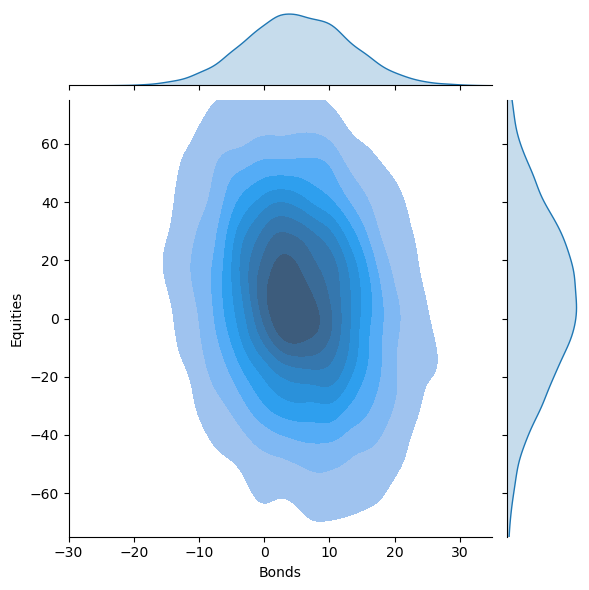

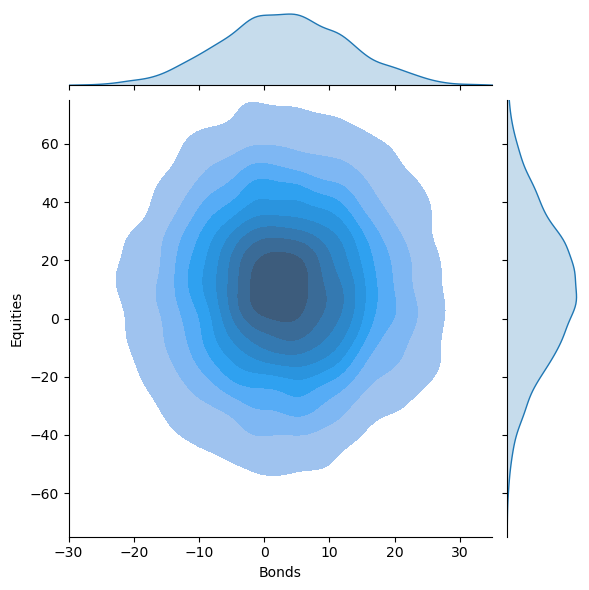

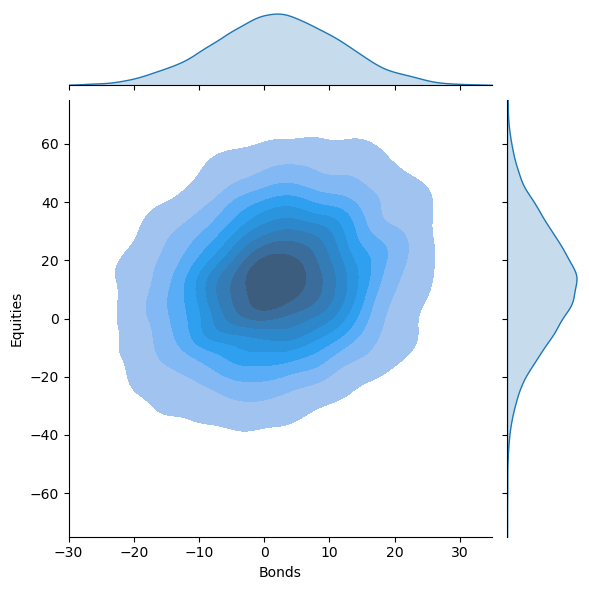

In [4]:
xlim = [-30, 35]
ylim = [-75, 75]
sns.jointplot(data=R_off, x='Bonds', y='Equities', kind='kde', fill=True, xlim=xlim, ylim=ylim)
sns.jointplot(data=R, x='Bonds', y='Equities', kind='kde', fill=True, xlim=xlim, ylim=ylim)
sns.jointplot(data=R_on, x='Bonds', y='Equities', kind='kde', fill=True, xlim=xlim, ylim=ylim)
plt.show()

# Optimization

In [5]:
# Long-only constraints
G = matrix(np.diag(-np.ones(2)))
h = matrix(np.zeros(2))
A = matrix(np.ones((1, 2)))
b = matrix(np.array([1.]))
Gq = [matrix(np.zeros((3, 2)))]
hq = [matrix(np.zeros(3))]

# Options and risk targets (12.5% volatility)
options['show_progress'] = False
scalar = 100
hq[0][0] = 0.125 * scalar

In [6]:
# Second-order code optimization
Gq[0][1:, 0:] = -cholesky(scalar**2 * sigma_off)
e_off = np.array(socp(c=matrix(-mu_off * scalar), Gl=G, hl=h, Gq=Gq, hq=hq, A=A, b=b)['x'])
Gq[0][1:, 0:] = -cholesky(scalar**2 * sigma)
e = np.array(socp(c=matrix(-mu * scalar), Gl=G, hl=h, Gq=Gq, hq=hq, A=A, b=b)['x'])
Gq[0][1:, 0:] = -cholesky(scalar**2 * sigma_on)
e_on = np.array(socp(c=matrix(-mu_on * scalar), Gl=G, hl=h, Gq=Gq, hq=hq, A=A, b=b)['x'])

In [7]:
# Verify risk targets
print(f'Risk off portfolio volatility {np.sqrt(e_off.T @ sigma_off @ e_off)}.')
print(f'Base case portfolio volatility {np.sqrt(e.T @ sigma @ e)}.')
print(f'Risk on portfolio volatility {np.sqrt(e_on.T @ sigma_on @ e_on)}.')

Risk off portfolio volatility [[0.12499996]].
Base case portfolio volatility [[0.125]].
Risk on portfolio volatility [[0.125]].


In [8]:
# Results Table 1.1
results = pd.DataFrame(
    np.round(100 * np.hstack((e_off, e, e_on)), 2),
    index=['Bonds', 'Equities'],
    columns=['Risk off', 'Base', 'Risk on'])
display(results)

,Risk off,Base,Risk on
Bonds,58.1,55.12,46.43
Equities,41.9,44.88,53.57


# Risk management analysis for risk off case

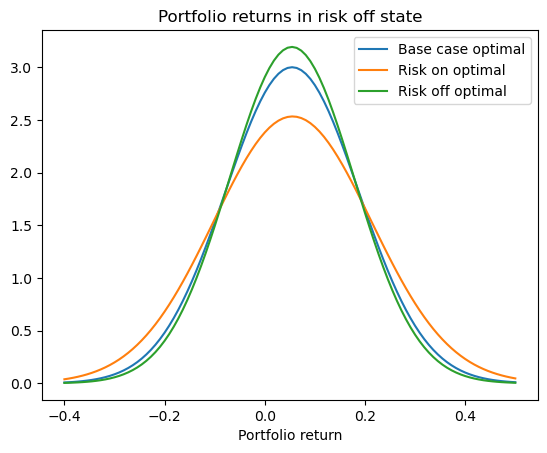

In [9]:
mu_pf_off_opt = e_off.T @ mu_off
sigma_pf_off_opt = np.sqrt(e_off.T @ sigma_off @ e_off)
mu_pf_off = e.T @ mu_off
sigma_pf_off = np.sqrt(e.T @ sigma_off @ e)
mu_pf_off_sub = e_on.T @ mu_off
sigma_pf_off_sub = np.sqrt(e_on.T @ sigma_off @ e_on)

x = np.linspace(-0.40, 0.50, 100)
dist_off_opt = norm(mu_pf_off_opt, sigma_pf_off_opt)
dist_off = norm(mu_pf_off, sigma_pf_off)
dist_off_sub = norm(mu_pf_off_sub, sigma_pf_off_sub)

plt.plot(x, dist_off.pdf(x)[0])
plt.plot(x, dist_off_sub.pdf(x)[0])
plt.plot(x, dist_off_opt.pdf(x)[0])
plt.legend(['Base case optimal', 'Risk on optimal', 'Risk off optimal'])
plt.title('Portfolio returns in risk off state')
plt.xlabel('Portfolio return')
plt.show()


In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.